In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

In [2]:
print("====Load Data====")
final_dataset = pd.read_csv("/kaggle/input/soybean-data/soybean_integrated_data_complete.csv", parse_dates=['Date'], index_col='Date')
print(f"Dataset shape: {final_dataset.shape}")
print(f"Date range: {final_dataset.index.min()} to {final_dataset.index.max()}")
print(f"Total days: {len(final_dataset)}")

# Display data overview
print(f"\nData columns:")
for i, col in enumerate(final_dataset.columns, 1):
    print(f"  {i:2d}. {col}")

====Load Data====
Dataset shape: (1825, 15)
Date range: 2020-09-21 00:00:00 to 2025-09-19 00:00:00
Total days: 1825

Data columns:
   1. soybean_price
   2. usd_brl_rate
   3. rain_Paranagua_PR
   4. temp_Paranagua_PR
   5. rain_MatoGrosso_MT
   6. temp_MatoGrosso_MT
   7. rain_Goias_GO
   8. temp_Goias_GO
   9. rain_MatoGrossoSul_MS
  10. temp_MatoGrossoSul_MS
  11. rain_RioGrandeSul_RS
  12. temp_RioGrandeSul_RS
  13. brent_oil_close
  14. cbot_soybean_close
  15. wti_oil_close


In [3]:
# # Define target variable and key exogenous variables
# target_var = 'soybean_price'


# # Select key exogenous variables
# key_exog_vars = [
#     'usd_brl_rate', 'cbot_soybean_close', 'brent_oil_close', 'wti_oil_close', 'temp_MatoGrosso_MT', 'rain_Paranagua_PR', 'temp_Paranagua_PR', 'rain_Goias_GO', 'temp_Goias_GO'
# ]

# selected_exog_vars = [
#     ['cbot_soybean_close', 
#      'brent_oil_close', 
#      # 'wti_oil_close', 
#      'usd_brl_rate', 'temp_MatoGrossoSul_MS', 'temp_Goias_GO', 'temp_MatoGrosso_MT', 'temp_Paranagua_PR', 'temp_RioGrandeSul_RS', 'rain_MatoGrossoSul_MS', 'rain_Paranagua_PR']
# ]

In [4]:
# 设置设备 (GPU 优先)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
class EarlyStopping:
    """简单的 PyTorch Early Stopping 实现"""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        if self.best_model_state:
            model.load_state_dict(self.best_model_state)

In [7]:
def create_window_norm_dataset(data, look_back=10, horizons=10, target_col_idx=0):
    """
    执行窗口归一化：
    输入 X 和 目标 y 都除以当前窗口 input 部分的第一行数据。
    
    Data: (T, n_features) 原始数值矩阵
    Returns:
        X_norm: (Samples, look_back, n_features)
        y_norm: (Samples, horizons) -> 仅针对 target 列
    """
    X, y = [], []
    
    # 确保是 numpy 数组
    if isinstance(data, pd.DataFrame):
        data = data.values
        
    T, n_features = data.shape
    
    for i in range(T - look_back - horizons + 1):
        # 1. 截取原始窗口
        window_X_raw = data[i : i+look_back, :] # (look_back, features)
        window_y_raw = data[i+look_back : i+look_back+horizons, target_col_idx] # (horizons, )
        
        # 2. 获取基准向量 (该窗口第一行)
        # 加上微小值防止除以 0
        base_row = window_X_raw[0, :] + 1e-8
        
        # 3. 归一化 X (每一列除以该列的基准)
        # 广播机制: (look_back, feat) / (1, feat)
        norm_X = (window_X_raw / base_row) - 1
        
        # 4. 归一化 y (只除以 target 的基准)
        target_base = base_row[target_col_idx]
        norm_y = (window_y_raw / target_base) - 1
        
        X.append(norm_X)
        y.append(norm_y)
        
    return np.array(X), np.array(y)

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_units=[50], output_size=10, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        # 容错处理：如果传入列表，取第一个元素作为隐藏层单元数
        # 如果传入单个整数，直接使用
        if isinstance(hidden_units, list):
            hidden_dim = hidden_units[0]
        else:
            hidden_dim = hidden_units
            
        # --- 只有一层 LSTM ---
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True, num_layers=1)
        
        # Dropout 层
        self.dropout = nn.Dropout(dropout)
        
        # 全连接输出层
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        
        # LSTM 前向传播
        # out shape: (batch, seq_len, hidden_dim)
        out, _ = self.lstm(x) 
        
        # 取序列的最后一个时间步 (Last Time Step)
        out = out[:, -1, :] # shape: (batch, hidden_dim)
        
        # Dropout 和 输出
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [9]:
def train_torch_model(model, X_train, y_train, epochs, batch_size, learning_rate, 
                      use_early_stop=True, es_patience=5, verbose=0):
    
    # 划分验证集
    split_idx = int(len(X_train) * 0.8)
    
    # 容错处理：数据太少时不划分
    if split_idx == 0 or split_idx == len(X_train):
        X_t, y_t = X_train, y_train
        X_v, y_v = None, None
        use_early_stop = False # 没验证集不能早停
    else:
        X_t = torch.tensor(X_train[:split_idx], dtype=torch.float32).to(device)
        y_t = torch.tensor(y_train[:split_idx], dtype=torch.float32).to(device)
        X_v = torch.tensor(X_train[split_idx:], dtype=torch.float32).to(device)
        y_v = torch.tensor(y_train[split_idx:], dtype=torch.float32).to(device)
    
    # 构造 Loader
    dataset = TensorDataset(torch.tensor(X_t, dtype=torch.float32).to(device) if X_v is None else X_t, 
                            torch.tensor(y_t, dtype=torch.float32).to(device) if X_v is None else y_t)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    es = EarlyStopping(patience=es_patience)
    
    # --- 新增：记录 History ---
    history = {'train_loss': [], 'val_loss': []}
    
    model.train()
    for epoch in range(epochs):
        train_loss_sum = 0.0
        for bx, by in loader:
            optimizer.zero_grad()
            output = model(bx)
            loss = criterion(output, by)
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            
        avg_train_loss = train_loss_sum / len(loader)
        history['train_loss'].append(avg_train_loss)
            
        # 验证
        val_loss = 0.0
        if X_v is not None:
            model.eval()
            with torch.no_grad():
                val_loss = criterion(model(X_v), y_v).item()
            model.train()
            history['val_loss'].append(val_loss)
        else:
            val_loss = avg_train_loss

        # 早停
        if use_early_stop:
            es(val_loss, model)
            if es.early_stop:
                if verbose > 0: print(f"Early stop at {epoch+1}")
                es.restore_best_weights(model)
                break
    
    # --- 返回模型和历史 ---
    return model, history

In [10]:
def lstm_cross_validation_window_norm(train_df, test_df, h, target_var, step_size, look_back, 
                                      exog_vars=None, refit=True, 
                                      hidden_units=[32], learning_rate=1e-3, dropout=0.2,
                                      epochs=50, batch_size=32, verbose=1,
                                      use_early_stop=True, es_patience=5):
    
    if exog_vars is None: exog_vars = []
    feature_cols = [target_var] + exog_vars
    target_col_idx = 0 
    n_features = len(feature_cols)
    
    train_vals = train_df[feature_cols].values
    test_vals = test_df[feature_cols].values
    
    preds_series = pd.Series(index=test_df.index, dtype=np.float64)
    n_test = len(test_df)
    
    history_list = []
    base_model = None

    # 1. 初始模型训练 (Refit=False 时使用，Refit=True 时可选，为了逻辑完整这里保留)
    if not refit:
        if verbose > 0: print("Training Base Model...")
        X_train, y_train = create_window_norm_dataset(train_vals, look_back, h, target_col_idx)
        base_model = LSTMModel(n_features, hidden_units, h, dropout).to(device)
        base_model, hist = train_torch_model(
            base_model, X_train, y_train, epochs, batch_size, learning_rate,
            use_early_stop=use_early_stop, es_patience=es_patience, verbose=verbose
        )
        history_list.append(hist)

    # 2. 滚动预测 (Expanding Window)
    for start_idx in range(0, n_test, step_size):
        
        end_idx = min(start_idx + h, n_test)
        current_horizon = end_idx - start_idx
        if current_horizon <= 0: break
        
        if verbose > 0: 
            print(f"Predicting index {start_idx} to {end_idx} (Len: {current_horizon})")

        # 获取所有可用的历史数据 (Expanding Window)
        full_history = np.concatenate([train_vals, test_vals[:start_idx]], axis=0)
        
        if len(full_history) < look_back:
            if verbose > 0: print("Not enough history, skipping.")
            continue

        fold_model = None
        
        if refit:
            # --- 修改点：使用全部历史数据 ---
            X_fold, y_fold = create_window_norm_dataset(full_history, look_back, h, target_col_idx)
            
            fold_model = LSTMModel(n_features, hidden_units, h, dropout).to(device)
            # 训练
            fold_model, hist = train_torch_model(
                fold_model, X_fold, y_fold, epochs, batch_size, learning_rate,
                use_early_stop=use_early_stop, es_patience=es_patience, verbose=1
            )
            history_list.append(hist)
        else:
            fold_model = base_model

        # 预测
        raw_window = full_history[-look_back:] 
        base_row = raw_window[0, :] + 1e-8
        input_norm = (raw_window / base_row) - 1
        
        x_in = torch.tensor(input_norm[np.newaxis, :, :], dtype=torch.float32).to(device)
        
        fold_model.eval()
        with torch.no_grad():
            y_pred_norm = fold_model(x_in).cpu().numpy()[0] 
        
        target_base = base_row[target_col_idx]
        y_pred_real_full = (y_pred_norm + 1) * target_base
        
        # 尾部截断
        y_pred_valid = y_pred_real_full[:current_horizon]
        
        # 填入
        indices = test_df.index[start_idx : end_idx]
        for idx, val in zip(indices, y_pred_valid):
            preds_series.loc[idx] = val
            
    if verbose > 0:
        print(f"Completed. Filled: {preds_series.notna().sum()}")
        
    return preds_series, history_list

In [11]:
from matplotlib import pyplot as plt
import pandas as pd




def prediction_plot(plt, train_data, true_values, predictions, title='Predictions vs True Values', freq='60D',target_var='Target Variable',look_back=60):
    plt.figure(figsize=(18,6))
    # plt.plot(fist_look_back_window_data.index, fist_look_back_window_data, label='True Values', color='blue')
    look_back_data = pd.Series(train_data[-look_back:], index=train_df.index[-look_back:])
    ture_data = pd.concat([look_back_data, true_values])
    plt.plot(ture_data.index, ture_data, label='True Values', color='blue')
    plt.plot(predictions.index, predictions, label='Predictions', color='red')
    # 每60天添加竖直虚线
    ax = plt.gca()
    for v in pd.date_range(start=true_values.index.min(), end=true_values.index.max(), freq=freq):
        ax.axvline(v, color='gray', linestyle='--', linewidth=0.7, alpha=0.6)
    plt.xlabel('Date')
    plt.ylabel(target_var)
    plt.title(title)
    plt.legend()




def plot_error_bar_chart(ax, metrics_df, color, error_label='MAE'):
    # 获取下划线前的name
    name = metrics_df['model'].iloc[0].split('_')[0]
    window = metrics_df['model'].iloc[0].split('_')[1]
    min_val = metrics_df[error_label].min()
    max_val = metrics_df[error_label].max()
    mean_val = metrics_df[error_label].mean()
    print(f"{name} mean_val: {mean_val:.4f}")



    lower_err = mean_val - min_val
    upper_err = max_val - mean_val

    # 画横向误差棒
    ax.errorbar(
        mean_val,             # x
        name,                 # y（分类名）
        xerr=[[lower_err],[upper_err]],
        fmt='o',              # 圆点
        markersize=8,
        color=color,          # 点颜色
        ecolor='black',         # 误差棒颜色统一
        elinewidth=1,
        capsize=8,
        capthick=1,
        label=name
    )

    # 为了好看一点，数值往左右各挪一点点
    span = max_val - min_val if max_val > min_val else mean_val * 0.1 + 1e-6
    dx = span * 0.01  # 控制文字和误差棒的水平距离
    # 均值数值
    ax.text(
        mean_val, name, f"{mean_val:.3f}",
        ha='center', va='top',
        fontsize=12
    )
    # 均值虚线
    ax.axvline(x=mean_val, ymin=0, ymax=1, color=color, linestyle='--', linewidth=1, alpha=0.7)
    # 左端点数值
    ax.text(
        min_val - dx, name, f"{min_val:.3f}",
        ha='left', va='bottom',
        fontsize=9
    )
    # 右端点数值
    ax.text(
        max_val + dx, name, f"{max_val:.3f}",
        ha='right', va='bottom',
        fontsize=9
    )
    ax.set_xlim(left=0)
    ax.set_xlim(right=2)
    ax.set_ylim(-1, 4)
    ax.set_xlabel(error_label)
    ax.set_ylabel('Model')
    ax.set_title(f'Windows for {window}-day Horizon')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.legend()


def plot_learning_curves(history_list, start_idx=0):
    """
    绘制训练和验证损失曲线
    
    参数:
    - history_list: lstm_cross_validation 返回的历史列表
    - start_idx: 从第几个 epoch 开始画 (有时前几个 epoch loss 极大，影响观察细节)
    """
    # 通常我们只看 Base Model (history_list[0]) 或者如果是 refit，看最后一个折
    # 这里默认画 Base Model 或者第一折的情况
    if not history_list:
        print("No history to plot.")
        return

    history = history_list[0] # 取第一次训练的记录
    
    train_loss = history['train_loss'][start_idx:]
    val_loss = history['val_loss'][start_idx:] if 'val_loss' in history and history['val_loss'] else []
    epochs = range(start_idx + 1, start_idx + 1 + len(train_loss))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    
    plt.title('Model Learning Curve (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # --- 自动诊断逻辑 ---
    if not val_loss:
        print("Diagnosis: No validation data available to diagnose.")
        return

    final_train = train_loss[-1]
    final_val = val_loss[-1]
    
    print("\n=== Model Diagnosis ===")
    print(f"Final Train Loss: {final_train:.6f}")
    print(f"Final Val Loss:   {final_val:.6f}")
    
    # 简单的启发式判断
    if final_train < final_val * 0.5: # 训练误差远小于验证误差
        print("Result: Potential OVERFITTING (过拟合)")
        print("Suggestion: Increase Dropout, simplify model (reduce units), or increase L2 regularization.")
    elif final_train > final_val * 1.2: # 训练误差居然比验证误差大很多 (罕见，通常是因为Dropout或验证集太简单)
        print("Result: Unusual (Train > Val). Check data distribution or reduce Dropout.")
    elif final_train > 0.1 and final_val > 0.1: # 两个都很大 (阈值需根据数据量级调整，这里是假设归一化后的数据)
        print("Result: Potential UNDERFITTING (欠拟合)")
        print("Suggestion: Increase model complexity (more layers/units), decrease regularization, or train longer.")
    else:
        print("Result: Good Fit (Reasonably close errors).")

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def evaluate_metrics(true_values, predictions):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    rnmse = rmse / np.mean(true_values)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    return mae, mse, rmse, rnmse, mape


def windowed_evaluate_metrics(model_name, true_values, predictions, window_size=10):
    # 不满足窗口大小的最后一部分也进行评估
    n = len(true_values)
    num_windows = (n + window_size - 1) // window_size  # 向上取整计算窗口数量
    metrics = []
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = min((i + 1) * window_size, n)
        window_true = true_values[start_idx:end_idx]
        window_pred = predictions[start_idx:end_idx]
        mae, mse, rmse, rnmse, mape = evaluate_metrics(window_true, window_pred)
        metrics.append({
            'model' : model_name,
            'window': i + 1,
            'start_index': start_idx,
            'end_index': end_idx - 1,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'RNMSE': rnmse,
            'MAPE': mape,
            
        })
    return pd.DataFrame(metrics)


In [13]:
train_size = int(len(final_dataset) * 0.8)
train_df = final_dataset.iloc[:train_size]
test_df = final_dataset.iloc[train_size:]

In [14]:
preds_lstmX, histories_lstmX = lstm_cross_validation_window_norm(
    train_df=train_df,
    hidden_units=[64],
    learning_rate=0.001,
    dropout=0.2,
    test_df=test_df,
    h=10,                    # 预测步长
    target_var=target_var,      # 你的目标列名
    step_size=10,            # 滑动步长
    look_back=60,            # 历史窗口
    exog_vars=key_exog_vars,     # 外生变量列名
    refit=True,             # 是否每步重训练
    epochs=100,
    batch_size=32,
    verbose=1,
    use_early_stop=True,
    es_patience=10
)

Predicting index 0 to 10 (Len: 10)
Early stop at 21
Predicting index 10 to 20 (Len: 10)
Early stop at 26
Predicting index 20 to 30 (Len: 10)
Early stop at 28
Predicting index 30 to 40 (Len: 10)
Early stop at 20
Predicting index 40 to 50 (Len: 10)
Early stop at 23
Predicting index 50 to 60 (Len: 10)
Early stop at 25
Predicting index 60 to 70 (Len: 10)
Early stop at 24
Predicting index 70 to 80 (Len: 10)
Early stop at 19
Predicting index 80 to 90 (Len: 10)
Early stop at 19
Predicting index 90 to 100 (Len: 10)
Early stop at 18
Predicting index 100 to 110 (Len: 10)
Early stop at 22
Predicting index 110 to 120 (Len: 10)
Early stop at 21
Predicting index 120 to 130 (Len: 10)
Early stop at 17
Predicting index 130 to 140 (Len: 10)
Early stop at 16
Predicting index 140 to 150 (Len: 10)
Early stop at 22
Predicting index 150 to 160 (Len: 10)
Early stop at 19
Predicting index 160 to 170 (Len: 10)
Early stop at 24
Predicting index 170 to 180 (Len: 10)
Early stop at 15
Predicting index 180 to 190 (L

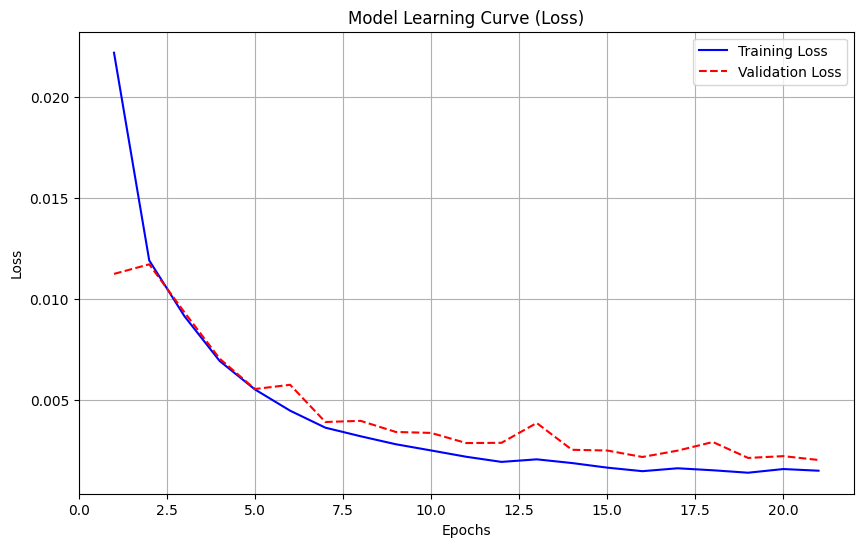


=== Model Diagnosis ===
Final Train Loss: 0.001499
Final Val Loss:   0.002031
Result: Good Fit (Reasonably close errors).


In [15]:
plot_learning_curves(histories_lstmX)

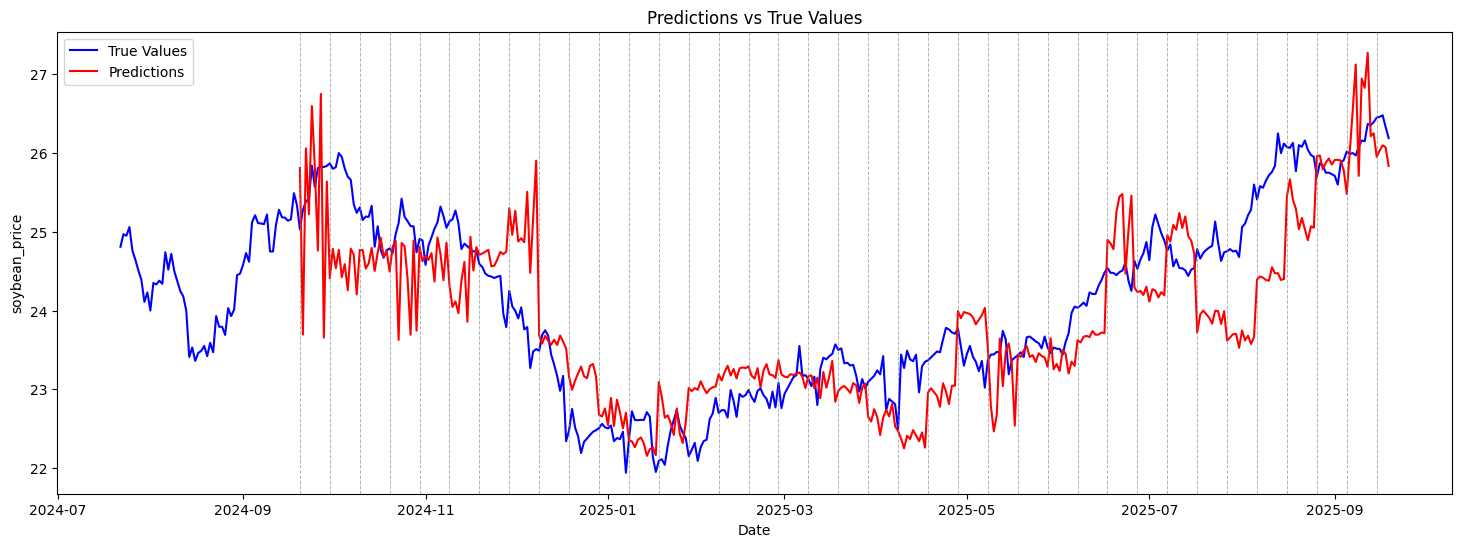

In [16]:
prediction_plot(plt, train_df[target_var],test_df[target_var], preds_lstmX, title='Predictions vs True Values', freq='10D',target_var='soybean_price',look_back=60)

In [17]:
preds_lstm, histories_lstm = lstm_cross_validation_window_norm(
    train_df=train_df,
    hidden_units=[64],
    learning_rate=0.001,
    dropout=0.2,
    test_df=test_df,
    h=10,                    # 预测步长
    target_var=target_var,      # 你的目标列名
    step_size=10,            # 滑动步长
    look_back=60,            # 历史窗口
    exog_vars=None,     # 外生变量列名
    refit=True,             # 是否每步重训练
    epochs=100,
    batch_size=32,
    verbose=1,
    # scale=True,
    use_early_stop=True,
    es_patience=10
)

Predicting index 0 to 10 (Len: 10)
Early stop at 14
Predicting index 10 to 20 (Len: 10)
Early stop at 13
Predicting index 20 to 30 (Len: 10)
Early stop at 17
Predicting index 30 to 40 (Len: 10)
Early stop at 13
Predicting index 40 to 50 (Len: 10)
Early stop at 12
Predicting index 50 to 60 (Len: 10)
Early stop at 16
Predicting index 60 to 70 (Len: 10)
Early stop at 12
Predicting index 70 to 80 (Len: 10)
Early stop at 13
Predicting index 80 to 90 (Len: 10)
Early stop at 12
Predicting index 90 to 100 (Len: 10)
Early stop at 12
Predicting index 100 to 110 (Len: 10)
Early stop at 14
Predicting index 110 to 120 (Len: 10)
Early stop at 13
Predicting index 120 to 130 (Len: 10)
Early stop at 12
Predicting index 130 to 140 (Len: 10)
Early stop at 12
Predicting index 140 to 150 (Len: 10)
Early stop at 12
Predicting index 150 to 160 (Len: 10)
Early stop at 12
Predicting index 160 to 170 (Len: 10)
Early stop at 13
Predicting index 170 to 180 (Len: 10)
Early stop at 12
Predicting index 180 to 190 (L

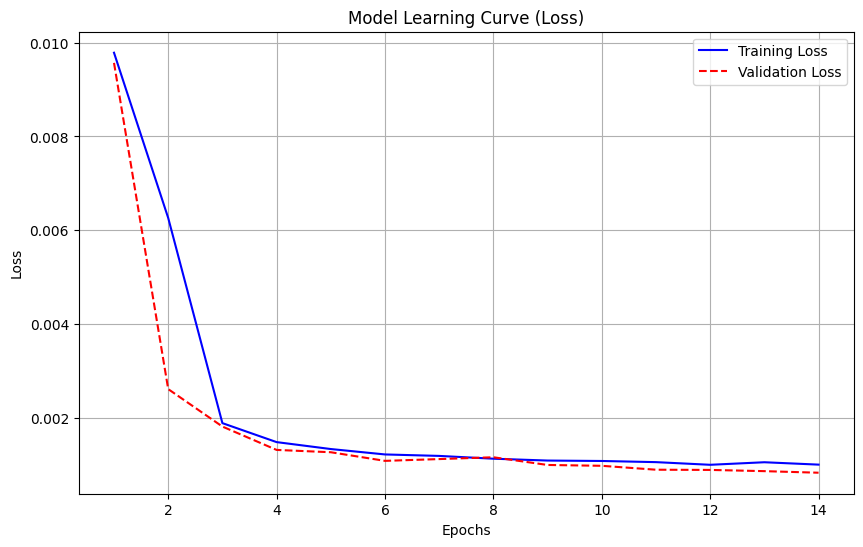


=== Model Diagnosis ===
Final Train Loss: 0.000996
Final Val Loss:   0.000824
Result: Unusual (Train > Val). Check data distribution or reduce Dropout.


In [18]:
plot_learning_curves(histories_lstm)

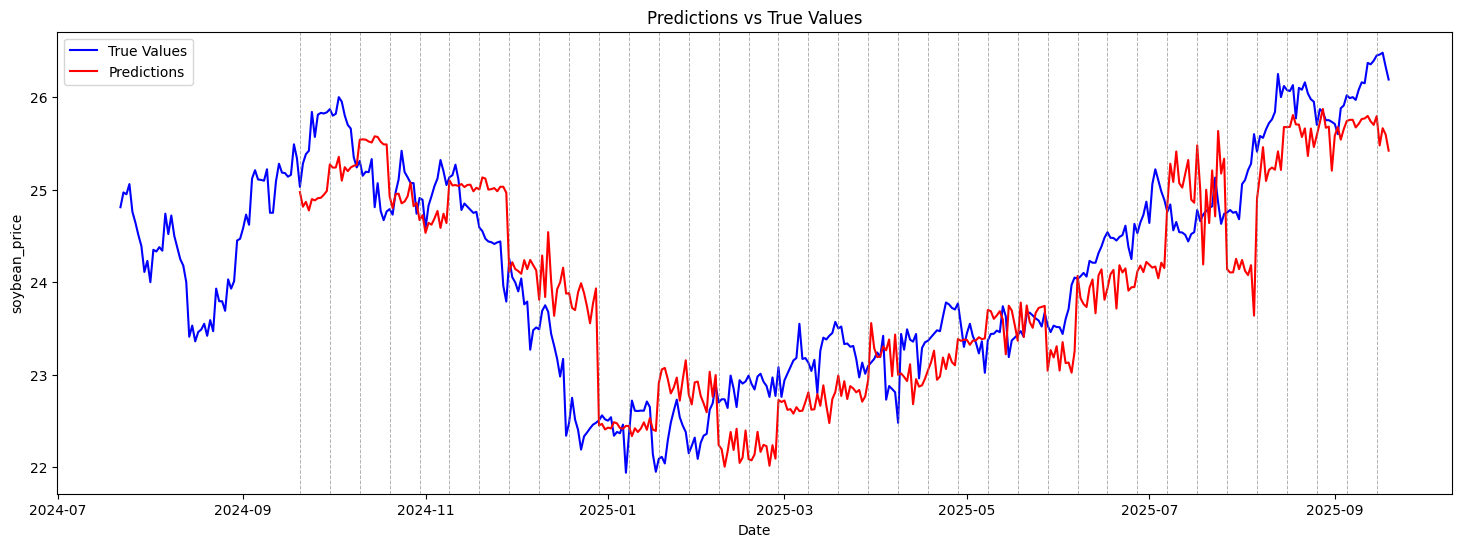

In [19]:
prediction_plot(plt, train_df[target_var],test_df[target_var], preds_lstm, title='Predictions vs True Values', freq='10D',target_var='soybean_price',look_back=60)

LSTM mean_val: 0.4718
LSTMX mean_val: 0.5601


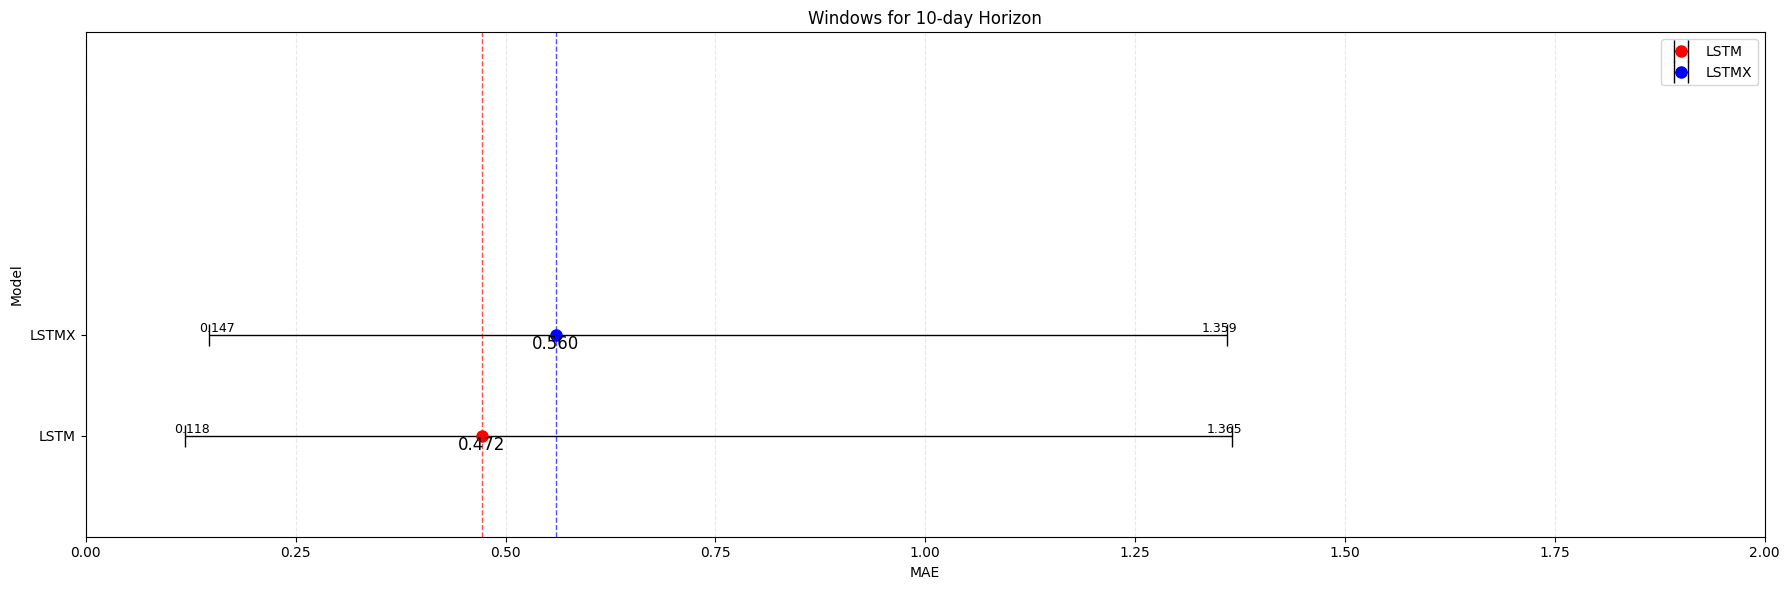

In [20]:

lstm_metrics_10 = windowed_evaluate_metrics("LSTM_10", test_df[target_var].values, preds_lstm, window_size=10)
lstmX_metrics_10 = windowed_evaluate_metrics("LSTMX_10", test_df[target_var].values, preds_lstmX, window_size=10)
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey=True)
plot_error_bar_chart(ax2, lstm_metrics_10,     color='red', error_label='MAE')
plot_error_bar_chart(ax2, lstmX_metrics_10,  color='blue', error_label='MAE')
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [17]:
import pywt  # 引入小波变换库

# 1. 定义小波去噪函数 (The "WT" part)
def wavelet_denoising(data, wavelet='db4', level=2):
    """
    修正版：增加长度检查，确保去噪后的数据长度与原始输入完全一致。
    """
    # 1. 记录原始长度
    original_len = len(data)
    
    # 2. 分解
    coeff = pywt.wavedec(data, wavelet, mode="per", level=level)
    
    # 3. 计算阈值 (通用阈值)
    sigma = (1/0.6745) * np.nanmedian(np.abs(coeff[-1] - np.nanmedian(coeff[-1])))
    uthesh = sigma * np.sqrt(2 * np.log(len(data)))
    
    # 4. 阈值处理 (Soft Thresholding)
    # 对所有细节系数(detail coefficients)进行去噪
    coeff[1:] = (pywt.threshold(i, value=uthesh, mode='soft') for i in coeff[1:])
    
    # 5. 重构
    recon_data = pywt.waverec(coeff, wavelet, mode='per')
    
    # --- 【关键修复】 长度对齐 ---
    if len(recon_data) > original_len:
        # 如果变长了，直接截断后面多余的部分
        recon_data = recon_data[:original_len]
    elif len(recon_data) < original_len:
        # 如果变短了（极少见），用最后一个值填充
        recon_data = np.pad(recon_data, (0, original_len - len(recon_data)), 'edge')
    
    recon_data = np.round(recon_data, 4)

    return recon_data

In [18]:
dn_data = wavelet_denoising(final_dataset[target_var])  # 对原始数据进行去噪
dn_data_series = pd.Series(dn_data, index=final_dataset.index)  # 转换为 Series 并保持索引一致
final_dataset[target_var] = dn_data_series.copy()  # 替换为去噪数据

In [33]:


# ==========================================
# 1. 全局配置
# ==========================================
HORIZON = 1          # 预测未来 1 天
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
HIDDEN_SIZE = 64
EPOCHS = 100
LOOK_BACK = 30 
TARGET_VAR = 'soybean_price'

# 变量列表
all_exog_vars = [
    'usd_brl_rate', 'cbot_soybean_close', 'brent_oil_close', 'wti_oil_close',
    'rain_MatoGrosso_MT', 'temp_MatoGrosso_MT', 'rain_RioGrandeSul_RS', 
    'temp_RioGrandeSul_RS', 'rain_Paranagua_PR', 'temp_Paranagua_PR',
    'rain_Goias_GO', 'temp_Goias_GO', 'rain_MatoGrossoSul_MS', 'temp_MatoGrossoSul_MS'
]

selected_exog_vars = ['cbot_soybean_close', 
                          # 'brent_oil_close', 
                          'wti_oil_close', 'usd_brl_rate', 'temp_MatoGrossoSul_MS', 'temp_Goias_GO', 'temp_MatoGrosso_MT', 'temp_Paranagua_PR', 'temp_RioGrandeSul_RS', 'rain_MatoGrossoSul_MS', 'rain_Paranagua_PR']

# # ==========================================
# # 2. 数据准备 (模拟数据)
# # ==========================================
# final_dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/time_series/soybean_integrated_data_complete.csv", parse_dates=['Date'], index_col='Date')
def get_data():
    """
    如果您的文件路径有效，读取文件；否则生成模拟数据。
    """
    file_path = "/kaggle/input/soybean-data/soybean_integrated_data_complete.csv"
    
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        print(">>> 成功加载真实数据文件。")
        return df
    except FileNotFoundError:
            
        return df
df = get_data()
# 2. 模型定义 (通用化 output_size)
# ==========================================
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        # 这里的 output_size 将由 horizon 决定
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_step = out[:, -1, :] 
        return self.fc(last_step)


# ==========================================
# 3. 实验流程 (支持 horizon 参数)
# ==========================================
def run_experiment(df ,name, feature_cols, horizon=1):
    """
    参数:
    horizon (int): 需要预测的未来天数 (默认为1)
    """
    print(f"\n>>> MODEL{name}开始运行实验 (特征数: {len(feature_cols)}, 预测天数: {horizon})")
    
    # --- A. 数据切分与归一化 ---
    train_size_raw = int(len(df) * 0.8)
    
    # Y Scaler
    scaler_y = MinMaxScaler((0, 1))
    train_y_raw = df[[TARGET_VAR]].iloc[:train_size_raw].values
    scaler_y.fit(train_y_raw)
    y_all_scaled = scaler_y.transform(df[[TARGET_VAR]].values)
    
    # X Scaler
    scaler_x = MinMaxScaler((0, 1))
    train_x_raw = df[feature_cols].iloc[:train_size_raw].values
    scaler_x.fit(train_x_raw)
    x_all_scaled = scaler_x.transform(df[feature_cols].values)
    
    # --- B. 构建滑窗数据集 (关键修改点) ---
    X, y = [], []
    # 确保只要有足够的 horizon 长度，就保留数据
    valid_len = len(df) - LOOK_BACK - horizon + 1
    
    for i in range(valid_len):
        # Input: 过去 LOOK_BACK 天
        X.append(x_all_scaled[i : i + LOOK_BACK, :])
        # Target: 未来 horizon 天 (这就变成了一个向量)
        y.append(y_all_scaled[i + LOOK_BACK : i + LOOK_BACK + horizon, 0])
        
    X = torch.FloatTensor(np.array(X)).to(DEVICE)
    y = torch.FloatTensor(np.array(y)).to(DEVICE)
    
    # --- C. 切分 Tensor ---
    train_split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:train_split_idx], X[train_split_idx:]
    y_train, y_test = y[:train_split_idx], y[train_split_idx:]
    
    print(f"训练集样本: {len(X_train)}, 测试集样本: {len(X_test)}")
    
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    
    # --- D. 初始化模型 (传入 horizon) ---
    model = SimpleLSTM(input_size=len(feature_cols), 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=horizon).to(DEVICE) # Output size = horizon
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # --- E. 训练 ---
    train_losses = []
    model.train()
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        for bx, by in train_loader:
            optimizer.zero_grad()
            pred = model(bx)
            loss = criterion(pred, by) # MSE 会自动计算两个向量之间的均方差
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {avg_loss:.5f}")
            
    # --- F. 预测与反归一化 (关键修改点) ---
    model.eval()
    with torch.no_grad():
        pred_test_scaled = model(X_test).cpu().numpy() # Shape: (Test_Size, horizon)
        y_test_real_scaled = y_test.cpu().numpy()      # Shape: (Test_Size, horizon)
        
    # 反归一化技巧: Scaler 期望输入是 (N, 1)，但我们要处理 (N, horizon)
    # 这里的做法是: 展平 -> 转换 -> 变回形状
    
    # 1. 预测值还原
    pred_flat = pred_test_scaled.flatten().reshape(-1, 1) # 变 (N*horizon, 1)
    pred_real_flat = scaler_y.inverse_transform(pred_flat)
    pred_test_real = pred_real_flat.reshape(-1, horizon)  # 变回 (N, horizon)
    
    # 2. 真实值还原
    y_flat = y_test_real_scaled.flatten().reshape(-1, 1)
    y_real_flat = scaler_y.inverse_transform(y_flat)
    y_test_real = y_real_flat.reshape(-1, horizon)
    
    return pred_test_real, y_test_real, train_losses

>>> 成功加载真实数据文件。


In [35]:
results = {}
y_test_real = {}
train_loss = {}

# 运行三种模式
modes = [
    ('NONE', target_var),
    ('SELECTED', target_var + selected_exog_vars),
    ('ALL', target_var + all_exog_vars)

]

for name, cols in modes:
    results[name], y_test_real[name], train_loss[name] = run_experiment(df, name, cols, HORIZON)


>>> MODELNONE开始运行实验 (特征数: 1, 预测天数: 1)
训练集样本: 1436, 测试集样本: 359
Epoch [10/100] - Train Loss: 0.00153
Epoch [20/100] - Train Loss: 0.00119
Epoch [30/100] - Train Loss: 0.00106
Epoch [40/100] - Train Loss: 0.00080
Epoch [50/100] - Train Loss: 0.00077
Epoch [60/100] - Train Loss: 0.00059
Epoch [70/100] - Train Loss: 0.00056
Epoch [80/100] - Train Loss: 0.00051
Epoch [90/100] - Train Loss: 0.00048
Epoch [100/100] - Train Loss: 0.00053

>>> MODELSELECTED开始运行实验 (特征数: 11, 预测天数: 1)
训练集样本: 1436, 测试集样本: 359
Epoch [10/100] - Train Loss: 0.00126
Epoch [20/100] - Train Loss: 0.00098
Epoch [30/100] - Train Loss: 0.00086
Epoch [40/100] - Train Loss: 0.00068
Epoch [50/100] - Train Loss: 0.00063
Epoch [60/100] - Train Loss: 0.00058
Epoch [70/100] - Train Loss: 0.00053
Epoch [80/100] - Train Loss: 0.00060
Epoch [90/100] - Train Loss: 0.00057
Epoch [100/100] - Train Loss: 0.00043

>>> MODELALL开始运行实验 (特征数: 15, 预测天数: 1)
训练集样本: 1436, 测试集样本: 359
Epoch [10/100] - Train Loss: 0.00147
Epoch [20/100] - Train Loss

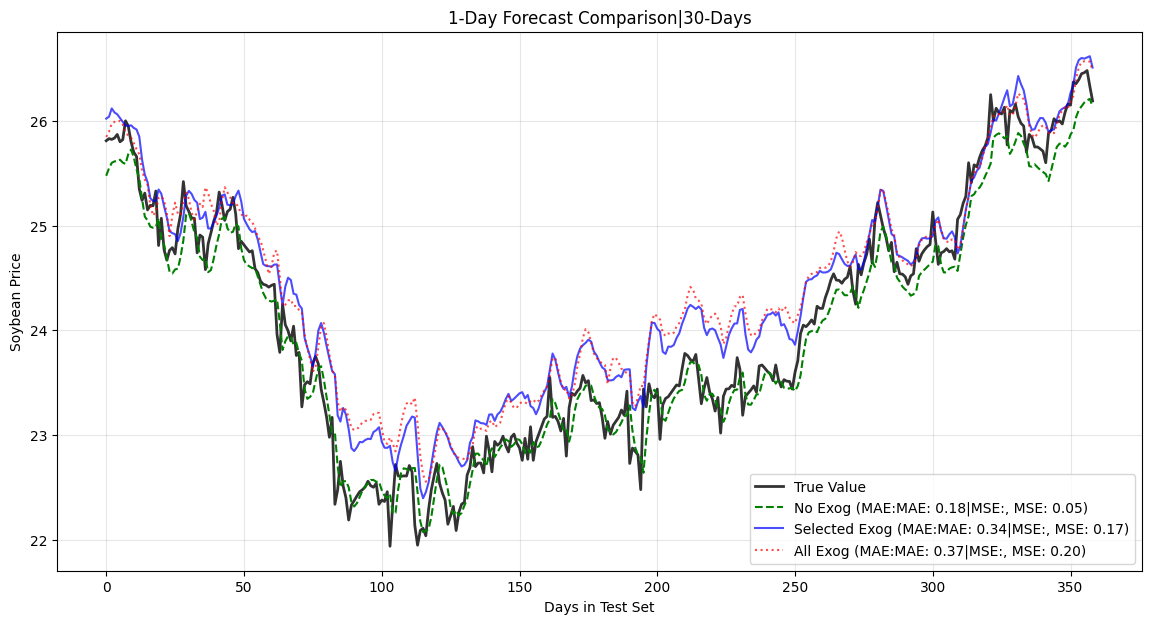

In [40]:
# 对齐长度 (防止切片导致的微小误差)
min_len = len(y_test_real['ALL'])
# for name in results:
#     min_len = min(min_len, len(results[name]))

# 截断
true_plot = y_test_real["ALL"]
preds_plot = {k: v[:min_len] for k, v in results.items()}

# 计算指标
metrics_mae = {}
metrics_mse = {}
for name, pred in preds_plot.items():
    mae = mean_absolute_error(true_plot, pred)
    mse = mean_squared_error(true_plot, pred)
    metrics_mae[name] = f"MAE: {mae:.2f}"
    metrics_mse[name] = f", MSE: {mse:.2f}"

# 画图
plt.figure(figsize=(14, 7))

# 真实值
plt.plot(true_plot, color='black', linewidth=2, label='True Value', alpha=0.8)

# 预测值
plt.plot(preds_plot['NONE'], color='green', linestyle='--', label=f"No Exog (MAE:{metrics_mae['NONE']}|MSE:{metrics_mse['NONE']})")
plt.plot(preds_plot['SELECTED'], color='blue', linestyle='-', alpha=0.7, label=f"Selected Exog (MAE:{metrics_mae['SELECTED']}|MSE:{metrics_mse['SELECTED']})")
plt.plot(preds_plot['ALL'], color='red', linestyle=':', alpha=0.7, label=f"All Exog (MAE:{metrics_mae['ALL']}|MSE:{metrics_mse['ALL']})")
plt.xlabel('Days in Test Set')
plt.ylabel('Soybean Price')
plt.title(f'{HORIZON}-Day Forecast Comparison|{LOOK_BACK}-Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()